# Projet Analyse de l'image

## Binôme : Antonin Arsac et Mathilde Perez

Dans ce projet nous allons utiliser le de neuronne produit par les rédacteurs de l'article : "Automatic diagnosis of the 12-lead ECG using a deep neural network". Ce réseau de neuronne permet de diagnostiquer des anomalies à partir d'ECG à 12 dérivations, qui sont données dans l'ordre suivant : {DI, DII, DIII, AVR, AVL, AVF, V1, V2, V3, V4, V5, V6}. Voici les anomalies qu'il prédit : 
- 1st degree AV block (1dAVb);
- right bundle branch block (RBBB);
- left bundle branch block (LBBB);
- sinus bradycardia (SB);
- atrial fibrillation (AF); 
- sinus tachycardia (ST).

L'objectif de ce projet va être d'adapter ce réseau de neuronne pour pouvoir diagnostiquer de nouvelles anomalies, toujours à partir d'ECG à 12 dérivations. En fait, ce ne sont pas de nouvelles anomalies, mais des classes d'anomalies, qui peuvent contenir en particulier des pathologies déjà détectées dans le réseau de l'article Nature. Ces classes sont au nombre de 4:
- MI : Myocardial Infarction 
- HYP : hypertrophy
- CD : Conduction Disturbance (qui contient par exemple l'anomalie RBBB)
- STTC : ST/T Change
 
Pour adapter le réseau de neuronne, nous allons recourir au transfert learning. D'abord, nous récupérons les données et le réseau, dont nous gelons toutes les couches. Après avoir traité les nouvelles données pour que le réseau puisse les prendre en entrée, nous changeons la couche de sortie du réseau pour qu'il ne prédise qu'un vecteur de taille 4. Puis nous l'entraînons avec seulement cette nouvelle couche.\
Selon les prédictions obtenues, nous procéderons à du fine tuning, qui consiste à dégeler le réseau et l'entraîner sur les nouvelles données.

## 1. Convert raw datasets from hospital centers into usable variables to train our model
### a. Import required libraries
    

In [60]:
import pandas as pd
import numpy as np
import wfdb
import ast #package typed-ast
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix,roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import accuracy_score,f1_score

import pickle
#Print versions
print('pandas version is :', pd.__version__)
print('numpy version is :', np.__version__)
print('wfdb version is :', wfdb.__version__)

pandas version is : 1.3.4
numpy version is : 1.21.2
wfdb version is : 3.4.1


In [2]:
from platform import python_version

print(python_version())

3.9.7


### Chargement des données

On a sauvegardé les données déjà transformées sous forme de pickle, pour un accès rapide sans avoir à refaire le processus de chargement et traitement des données à chaque fois. On les charge ci-dessous :

In [15]:
path_pkl =  './data/'   ## accès au fichier dans lequel on a save les pkl

with open(path_pkl +'Xtrain_.pkl','rb') as f: 
    X_train_ = pickle.load(f)
    
with open(path_pkl +'Xtest_.pkl','rb') as f: 
    X_test_ = pickle.load(f)
    
with open(path_pkl +'Ytrain.pkl','rb') as f: 
    y_train = pickle.load(f)

with open(path_pkl +'Ytest.pkl','rb') as f: 
    y_test = pickle.load(f)

### b. Get the data to prepare the training phase



In [3]:
# from tqdm import tqdm
# def load_raw_data(df, sampling_rate, path):
#     data = []
#     if sampling_rate == 100:
#         data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
#     else:
#         i=0
#         for f in tqdm(df.filename_hr):
#             data.append(wfdb.rdsamp(path+f))
#             i+=1

#     data = np.array([signal for signal, meta in data])
#     return data

# path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'  #SET YOUR DIRECTORY HERE!!!
# #path = '/Users/lrisser/Taff/2021_NNetECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
# sampling_rate=500

# # load and convert annotation data
# Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

# Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# # Load raw signal data
# X = load_raw_data(Y, sampling_rate, path)
# #X = load_raw_data(Y[0:1000], sampling_rate, path)

# # Load scp_statements.csv for diagnostic aggregation
# agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
# agg_df = agg_df[agg_df.diagnostic == 1]

# def aggregate_diagnostic(y_dic):
#     tmp = []
#     for key in y_dic.keys():
#         if key in agg_df.index:
#             tmp.append(agg_df.loc[key].diagnostic_class)
#     return list(set(tmp))

# # Apply diagnostic superclass
# Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
# #Y = Y[0:1000]

# # Split data into train and test
# test_fold = 10
# # Train
# X_train = X[np.where(Y.strat_fold != test_fold)]
# y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# # Test
# X_test = X[np.where(Y.strat_fold == test_fold)]
# y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

100%|████████████████████████████████████████████████████████████████████████████| 21837/21837 [04:10<00:00, 87.23it/s]


In [4]:
# def delete_unk_ecg(x,y):
#     y = list(y)
#     x_processed,y_processed = [],[]
#     for index,dis in enumerate(y):
#         if dis != []:
#             x_processed.append(x[index])
#             y_processed.append(y[index])
#     return x_processed,y_processed


# X_train,y_train = delete_unk_ecg(X_train,y_train)
# X_test,y_test = delete_unk_ecg(X_test,y_test)
            
# y_train = np.array(y_train,dtype=object)
# y_test = np.array(y_test,dtype=object)
# X_train = np.array(X_train)
# X_test = np.array(X_test)

In [5]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(19267,)
(19267, 5000, 12)
(2163, 5000, 12)
(2163,)


###    c. Convert the y_train into a usable format  
    

In [6]:
# #Define the diseases
# diseases = ["NORM","MI","HYP","CD","STTC"]

# #Create a RIBEIRO format training data
# def Ribeiro_convert(y_train):
    
#     y_train = list(y_train)

#     y_train_ = [[0,0,0,0] for i in list(y_train)]
#     for index, info in enumerate(y_train):

#         for disease in info:

#             if disease != 'NORM':
#                 y_train_[index][diseases.index(disease)-1] = 1

#     y_train_ = np.array(y_train_)
#     return y_train_

# y_train = Ribeiro_convert(y_train)
# y_test = Ribeiro_convert(y_test)

# print(y_train.shape)
# print(y_test.shape)

# ##Reformat the ECG aquisition, 4048 samples needed.

(19267, 4)
(2163, 4)


### d. Rescale the data
    Ribeiro is adaptated to 400Hz/10sec : 4096 samples, on this dataset the ECG are converted into 5000 samples array, we have to interpolate and convert array with shape (5000,) into (4096,)
    

In [7]:
# import cv2 # opencv
# from tqdm import tqdm

# def convert_X(X,scale):
#     X_conv = np.empty((X.shape[0], 4096, 12))
#     for index,array in enumerate(X):
#         array = cv2.resize(array,(12,scale))
#         X_conv[index,:,:]=array
#     return X_conv
    
# X_train_=convert_X(X_train,4096)    
# X_test_=convert_X(X_test,4096)    

# print(X_train.shape)
# print(X_train_.shape)
# print(X_test.shape)
# print(X_test_.shape)

(19267, 5000, 12)
(19267, 4096, 12)
(2163, 5000, 12)
(2163, 4096, 12)


#### check the interpolation

y= [0 0 0 1]
Disease = STTC


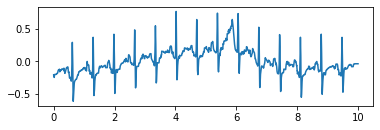

In [87]:
import numpy as np
import matplotlib.pyplot as plt

y = np.linspace(0,10,5000)
y_ =np.linspace(0,10,4096)

ObsID=20     #you can change the obsevations here
ChannelID=1 #you can change the channel here

# plt.subplot(2, 1, 1)
# plt.plot(y,X_train[ObsID,:,ChannelID])
plt.subplot(2, 1, 2)
plt.plot(y_,X_train_[ObsID,:,ChannelID])

print('y=',y_train[ObsID])

if (y_train[ObsID][0]==1):
    print("Disease = MI")
elif (y_train[ObsID][1]==1):
    print("Disease = HYP")
elif (y_train[ObsID][2]==1):
    print("Disease = CD")
elif (y_train[ObsID][3]==1):
    print("Disease = STTC")

### Etude des données :

On fait une rapide étude des données, pour savoir si les classes (positif/négatif) sont équilibrées ou non.

In [25]:
print("nombre de positifs pour MI", sum(y_train[:,0]))
print("nombre de positifs pour HYP", sum(y_train[:,1]))
print("nombre de positifs pour CD", sum(y_train[:,2]))
print("nombre de positifs pour STTC", sum(y_train[:,3]))
print("")
print("taille de y_train :", y_train.shape)
print("")

print("proportion de positifs pour MI", sum(y_train[:,0]/y_train.shape[0]*100))
print("proportion de positifs pour HYP", sum(y_train[:,1]/y_train.shape[0]*100))
print("proportion de positifs pour CD", sum(y_train[:,2]/y_train.shape[0]*100))
print("proportion de positifs pour STTC", sum(y_train[:,3]/y_train.shape[0]*100))



nombre de positifs pour MI 4933
nombre de positifs pour HYP 2392
nombre de positifs pour CD 4409
nombre de positifs pour STTC 4727

taille de y_train : (19267, 4)

proportion de positifs pour MI 25.603363263611445
proportion de positifs pour HYP 12.415010120932207
proportion de positifs pour CD 22.883687133440677
proportion de positifs pour STTC 24.534177609384006
16461
16461


On peut voir que les données sont plutôt déséquilibrées entre les diagnostics positifs et les négatifs : pour chaque maladie, il y a au moins 75% de personnes saines. Cela est à prendre en compte dans l'élaboration de notre classifieur : il est possible qu'il ne prenne pas en compte les personnes présentant des anomalies car elles sont en trop faible nombre par rapport aux personnes saines.\
C'est surtout le cas pour la HYP.

In [ ]:
## Sauvegarde des données en Pickle
# path_pkl =  './data/'   ## accès au fichier dans lequel on veut save les pkl
# with open(path_pkl +'Xtrain_.pkl','wb') as f: 
#     pickle.dump(X_train_, f)
    
# with open(path_pkl +'Xtest_.pkl','wb') as f: 
#     pickle.dump(X_test_, f)
    
# with open(path_pkl +'Ytrain.pkl','wb') as f: 
#     pickle.dump(y_train, f)

# with open(path_pkl +'Ytest.pkl','wb') as f: 
#     pickle.dump(y_test, f)

### Importation du modèle

In [4]:
import argparse
#warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from datasets import ECGSequence

### Chargement du modèle

parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
parser.add_argument('path_to_hdf5', type=str,
                    help='path to hdf5 file containing tracings')
parser.add_argument('path_to_model',  # or model_date_order.hdf5
                    help='file containing training model.')
parser.add_argument('--dataset_name', type=str, default='tracings',
                    help='name of the hdf5 dataset containing tracings')
parser.add_argument('--output_file', default="./dnn_output2.npy",  # or predictions_date_order.csv
                    help='output csv file.')
parser.add_argument('-bs', type=int, default=32,
                    help='Batch size.')

args, unk = parser.parse_known_args(["./data/ecg_tracings.hdf5","./data/model/model.hdf5"])
if unk:
    warnings.warn("Unknown arguments:" + str(unk) + ".")

# Import data
seq = ECGSequence(args.path_to_hdf5, args.dataset_name, batch_size=args.bs)
#Import model
model = load_model(args.path_to_model, compile=False)



    

In [29]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][

### Transfert Learning

In [10]:
## On gèle le modèle
model.trainable = False

In [11]:
## On récupère les outputs de chaque couches du modele, sauf la dernière
model_output = [layer.output for layer in model.layers[:-1]]
## On crée des nouvelles couches de sortie
new_end = Dense(4096, activation = 'relu')(model_output[-1])
new_end = Dense(4096, activation = 'relu')(new_end)

## On veut des prédictions binaires -> sigmoid
new_end = Dense(4, activation = 'sigmoid')(new_end)

## On crée notre nouveau réseau qui contient le réseau de Nature, et les nouvelles couches de sortie
new_model = tensorflow.keras.Model(inputs = model.input, outputs = new_end)

In [12]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][

Ci-dessous, on entraîne d'abord le réseau avec toutes les couches gelées sauf les dernières.

In [18]:
new_model.compile(loss = 'binary_crossentropy', optimizer = Adam())
new_model.fit(X_train_, y_train, batch_size = 128, epochs = 12, validation_split = 0.2)

Epoch 1/12
121/121 [==============================] - 283s 2s/step - loss: 0.4551 - val_loss: 0.4470
Epoch 2/12
121/121 [==============================] - 274s 2s/step - loss: 0.4264 - val_loss: 0.4312
Epoch 3/12
121/121 [==============================] - 281s 2s/step - loss: 0.4186 - val_loss: 0.4342
Epoch 4/12
121/121 [==============================] - 280s 2s/step - loss: 0.4149 - val_loss: 0.4272
Epoch 5/12
121/121 [==============================] - 276s 2s/step - loss: 0.4136 - val_loss: 0.4199
Epoch 6/12
121/121 [==============================] - 276s 2s/step - loss: 0.4115 - val_loss: 0.4202
Epoch 7/12
121/121 [==============================] - 276s 2s/step - loss: 0.4091 - val_loss: 0.4252
Epoch 8/12
121/121 [==============================] - 275s 2s/step - loss: 0.4069 - val_loss: 0.4225
Epoch 9/12
121/121 [==============================] - 288s 2s/step - loss: 0.4074 - val_loss: 0.4217
Epoch 10/12
121/121 [==============================] - 309s 3s/step - loss: 0.4063 - val_lo

In [19]:
df_predicts = new_model.predict(X_test_)
df_predicts = np.round(df_predicts)
df_predicts = pd.DataFrame(data = df_predicts, columns = ["MI","HYP","CD","STTC"])

## On save les prédictions
# df_predicts.to_csv('Pred_Dense.csv')

In [41]:
## On met sous forme de dataframe pour pouvoir étudier les résultats
df_test = pd.DataFrame(data = y_test, columns = ["MI","HYP","CD","STTC"])
df_predicts = pd.read_csv('Pred_Dense.csv',sep=",",index_col=0)

#### Première étude des résultats

In [45]:
cm = confusion_matrix(df_predicts["MI"], df_test["MI"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour MI :", accuracy_score(df_predicts["MI"], df_test["MI"])*100)
print("F1-Score pour MI :", f1_score(df_predicts["MI"], df_test["MI"])*100)

Matrice de confusion [[1539  409]
 [  71  144]]
Pourcentage d'erreur 22.191400832177532
Score pour MI : 77.80859916782246
F1-Score pour MI : 37.50000000000001


In [46]:
cm = confusion_matrix(df_predicts["HYP"], df_test["HYP"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour HYP :", accuracy_score(df_predicts["HYP"], df_test["HYP"])*100)
print("F1-Score pour HYP :", f1_score(df_predicts["HYP"], df_test["HYP"])*100)

Matrice de confusion [[1900  263]
 [   0    0]]
Pourcentage d'erreur 12.159038372630606
Score pour HYP : 87.8409616273694
F1Score pour HYP : 0.0


In [49]:
cm = confusion_matrix(df_predicts["CD"], df_test["CD"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour CD :", accuracy_score(df_predicts["CD"], df_test["CD"])*100)
print("F1-Score pour CD :", f1_score(df_predicts["CD"], df_test["CD"])*100)

Matrice de confusion [[1635  277]
 [  30  221]]
Pourcentage d'erreur 14.193250115580213
Score pour CD : 85.80674988441979
F1-Score pour CD : 59.012016021361816


In [48]:
cm = confusion_matrix(df_predicts["STTC"], df_test["STTC"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("score du dnn pour STTC :", accuracy_score(df_predicts["STTC"], df_test["STTC"])*100)
print("F1-score du dnn pour STTC :", f1_score(df_predicts["STTC"], df_test["STTC"])*100)

Matrice de confusion [[1586  428]
 [  54   95]]
Pourcentage d'erreur 22.283865002311604
score du dnn pour STTC : 77.71613499768839
F1-score du dnn pour STTC : 28.27380952380952


Après avoir effectué un transfert learning, on constate avec les matrices de confusion que le réseau a beaucoup de mal à prédire des anomalies. C'est ce que nous craignions lorsque nous avons analysé les données précédemment. En particulier, il ne détecte aucune anomalie du groupe HYP.\
On note aussi que le f1-score est très faible, ce qui montre bien l'imprécision du modèle.

Nous allons utiliser du fine-tuning, pour essayer d'obtenir de meilleurs résultats.

### Fine-tuning

Le fine tuning consiste à dégeler le réseau de neuronne et l'entraîner sur les nouvelles données, tout en gardant les couches Dense entraînées précédemment.

In [7]:
## On dégèle le modèle
model.trainable = True

In [8]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][0]

In [26]:
new_model.compile(loss = 'binary_crossentropy',  optimizer = Adam(1e-5))

In [27]:
#new_model.summary()

In [28]:
new_model.fit(X_train_, y_train, batch_size = 128, epochs = 12, validation_split = 0.2)

Epoch 1/12
121/121 [==============================] - 986s 8s/step - loss: 0.4063 - val_loss: 0.4223
Epoch 2/12
121/121 [==============================] - 937s 8s/step - loss: 0.4037 - val_loss: 0.4186
Epoch 3/12
121/121 [==============================] - 920s 8s/step - loss: 0.4026 - val_loss: 0.4142
Epoch 4/12
121/121 [==============================] - 931s 8s/step - loss: 0.3990 - val_loss: 0.4122
Epoch 5/12
121/121 [==============================] - 919s 8s/step - loss: 0.3991 - val_loss: 0.4114
Epoch 6/12
121/121 [==============================] - 935s 8s/step - loss: 0.3957 - val_loss: 0.4101
Epoch 7/12
121/121 [==============================] - 981s 8s/step - loss: 0.3960 - val_loss: 0.4092
Epoch 8/12
121/121 [==============================] - 944s 8s/step - loss: 0.3946 - val_loss: 0.4080
Epoch 9/12
121/121 [==============================] - 914s 8s/step - loss: 0.3926 - val_loss: 0.4067
Epoch 10/12
121/121 [==============================] - 887s 7s/step - loss: 0.3915 - val_lo

In [29]:
df_predicts2 = new_model.predict(X_test_)
df_predicts2 = np.round(df_predicts2)
df_predicts2 = pd.DataFrame(data = df_predicts2, columns = ["MI","HYP","CD","STTC"])
# df_predicts2.to_csv('Pred_Fine-Tuning.csv')

In [51]:
df_predicts2= pd.read_csv("Pred_Fine-Tuning.csv",sep=',',index_col=0)

### Analyse des résultats

In [78]:
cm = confusion_matrix(df_predicts2["MI"], df_test["MI"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)

print("F1-score du dnn pour MI :", f1_score(df_predicts["MI"], df_test["MI"])*100)

Matrice de confusion [[1535  394]
 [  75  159]]
Pourcentage d'erreur 21.68284789644013
F1-score du dnn pour MI : 37.50000000000001


In [79]:
cm = confusion_matrix(df_predicts2["HYP"], df_test["HYP"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)

print("F1-score du dnn pour HYP :", f1_score(df_predicts["HYP"], df_test["HYP"])*100)

Matrice de confusion [[1900  263]
 [   0    0]]
Pourcentage d'erreur 12.159038372630606
F1-score du dnn pour HYP : 0.0


In [80]:
cm = confusion_matrix(df_predicts2["CD"], df_test["CD"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)

print("F1-score du dnn pour CD :", f1_score(df_predicts["CD"], df_test["CD"])*100)

Matrice de confusion [[1623  239]
 [  42  259]]
Pourcentage d'erreur 12.991215903837263
F1-score du dnn pour CD : 59.012016021361816


In [81]:
cm = confusion_matrix(df_predicts2["STTC"], df_test["STTC"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)

print("F1-score du dnn pour STTC :", f1_score(df_predicts["STTC"], df_test["STTC"])*100)

Matrice de confusion [[1585  420]
 [  55  103]]
Pourcentage d'erreur 21.96024040684235
F1-score du dnn pour STTC : 28.27380952380952


Même si on note une légère amélioration de la précision, les matrices de confusion montrent une fois de plus que notre classifieur n'arrive pas bien à prédire les anomalies.

On trace ci-dessous les courbes Precision-Recall pour chaque anomalie prédite par le réseau. On ne trace pas les courbes ROC car le jeu de donnée compte bien plus de diagnostique négatif que de positif. Ainsi, la courbe roc n'a pas grand intérêt, puisqu'elle est composée de probabilité conditionnées sur la classe positive. Ainsi, elles resteront les mêmes quelque soit la valeur de la probabilité d'avoir un positif.\
Au contraire, la précision est conditionnée sur l'estimation d'avoir un positif. Ainsi, elle a bien plus d'intérêt dans notre cas où les données sont déséquilibrées.


C:\Users\anton\.conda\envs\spyder\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


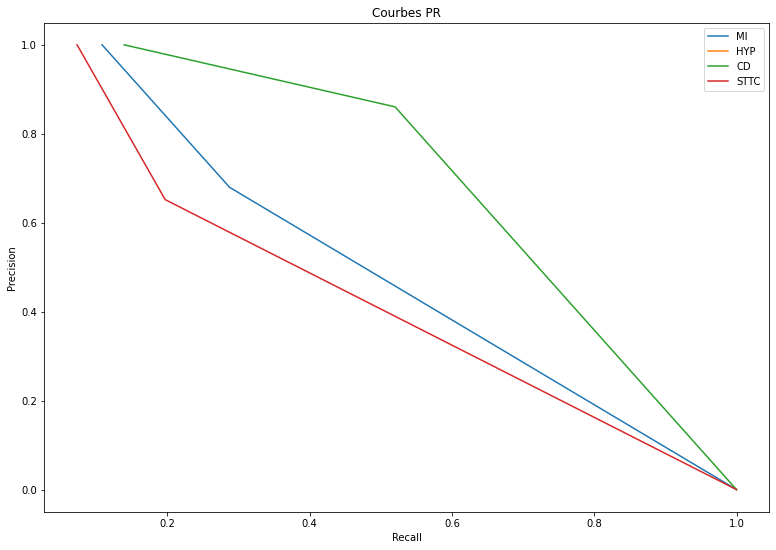

In [61]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = precision_recall_curve(df_predicts2["MI"], df_test["MI"])
fper2, tper2, thresholds = precision_recall_curve(df_predicts2["HYP"], df_test["HYP"])
fper3, tper3, thresholds = precision_recall_curve(df_predicts2["CD"], df_test["CD"])
fper4, tper4, thresholds = precision_recall_curve(df_predicts2["STTC"], df_test["STTC"])


plt.plot(fper1, tper1, label='MI')
plt.plot(fper2, tper2, label='HYP')
plt.plot(fper3, tper3, label='CD')
plt.plot(fper4, tper4, label='STTC')



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes PR')
plt.legend()
plt.show()



Aucune courbe ne s'affiche pour **HYP**. C'est normal car le réseau n'a prédit aucune anomalie de ce genre. 

Pour les autres maladies, la courbe confirme ce que l'on pensait précédemment. Notre DNN est très mauvais puisqu'il ne fait pas mieux ou à peine mieux qu'un classifieur qui classifierait les données aléatoirement (droite passant par les points $(0,1)$ et $(1,0)$).

Ce phénomène est très certainement dû au fait que dans les données, il y a peu de diagnostics positifs comparé aux diagnostics négatifs. Cela se confirme nettement car l'anomalie la moins représentée dans les données, la **HYP** est celle dont le réseau n'arrive pas à prédire de cas positif. 


Pour améliorer notre réseau de neuronne il y a plusieurs pistes d'amélioration. Tout d'abord, on pourrait essayer de mettre plus de poids sur les ECG dont le diagnostic est positif. Cela pourrait être réalisable par exemple en ajoutant une pénalisation sur la fonction de perte.

Une autre idée aurait été d'essayer de corréler les nouvelles données avec les anciennes (avec une ACP par exemple), pour que le réseau puisse reconnaître des pattern dans les ECG, et ainsi mieux classer les données.

Nous constatons toutefois que le réseau arrive quand même à prédire certaines pathologies. Cela s'explique aussi par le fait que les anomalies que nous souhaitons détecter ici sont des "groupes" d'anomalie. Ils contiennent en particulier des anomalies que le réseau entraîné de l'article Nature prédisait avant. Or, nous avons gardé les paramètres de ce réseau lors du trasnfert learning. Donc il se peut, que notre "nouveau" réseau arrive encore à reconnaître plusieurs de ces pathologies. Cela expliquerait en partie la détection de certaines maladies.